In [1]:
import pandas as pd
import numpy as np
import sys
from datetime import datetime
from matplotlib import pyplot as plt
import plotly.graph_objects as go

In [2]:
df_calls = pd.read_csv('../cotton/data/df_cotton_calls.csv')
df_prices = pd.read_csv('../cotton/data/df_cotton_prices.csv').rename(columns={'a_index':'price'})

<Axes: xlabel='date'>

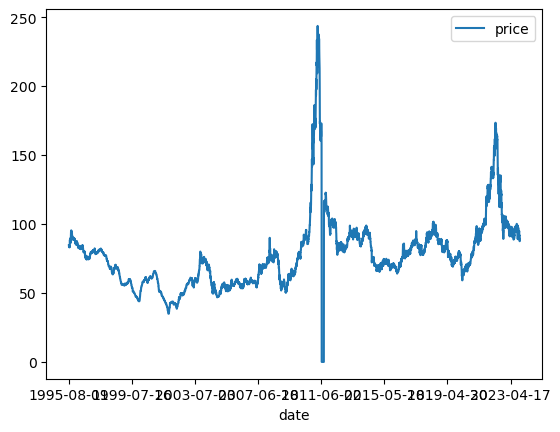

In [3]:
df_prices.plot(x='date', y='price')

In [4]:
# Overwrite prices from 30 days prior to the date at which there is an error in the data, up till the end of the problem.
# Need to overwrite with np.nan rather than dropping the rows so that the time integrigty of the outcome variables during 
# these is maintained. Otherwise prices from beyond the period will be brought forward into the outcomes prior to the period
df_prices['price'] = np.where((df_prices.date < '2011-05-10') | (df_prices.date > '2011-07-29'), df_prices['price'], np.nan)

<Axes: xlabel='date'>

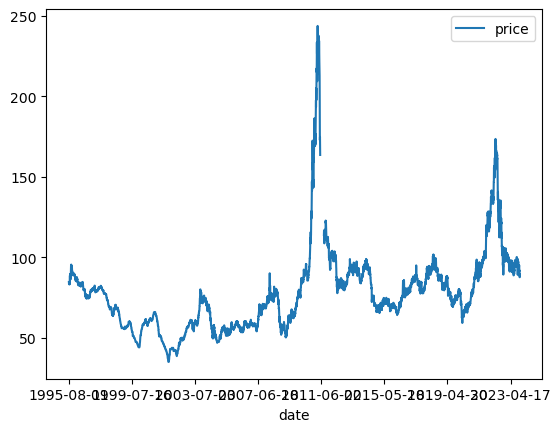

In [5]:
df_prices.plot(x='date', y='price')

In [6]:
def add_column_cyclical_features(df, datetime_var, period, start_num=0):
    
    values = 2 * np.pi * (df[datetime_var] - start_num) / period
    kwargs = {f'sin_{datetime_var}': lambda x: np.sin(values),
              f'cos_{datetime_var}': lambda x: np.cos(values)}
    
    return df.assign(**kwargs)

In [40]:
class OnCallPrep:
    
    def __init__(self, df_calls):
        
        self.df_calls = df_calls.copy()
        
        self._create_misc_vars()

    def _create_misc_vars(self):
        
        self.df_calls['unfixed_net'] = self.df_calls['unfixed_purchase'] - self.df_calls['unfixed_sale']
        self.df_calls['report_month'] = pd.to_datetime(self.df_calls['date']).dt.month
        self.df_calls['report_year'] = pd.to_datetime(self.df_calls['date']).dt.isocalendar().year
        self.df_calls['futures_datetime'] = pd.to_datetime(self.df_calls['month'])
        self.df_calls['futures_month'] = pd.to_datetime(self.df_calls['month']).dt.month
        self.df_calls['futures_year'] = pd.to_datetime(self.df_calls['month']).dt.isocalendar().year

        self.df_calls['futures_month_ranked'] = self.df_calls.groupby('date')['futures_datetime'].rank(method='dense')

        self.df_calls['season'] = np.where(self.df_calls['report_year'] == self.df_calls['futures_year'], 'season1',
                               np.where(self.df_calls['report_year'] + 1 == self.df_calls['futures_year'], 'season2',
                                  np.where(self.df_calls['report_year'] + 2 == self.df_calls['futures_year'], 'season3', 'season_OTHER')))

        self.df_calls = self.df_calls[self.df_calls.season.isin(['season1', 'season2'])].copy()

    def _create_call_features(self, df_calls, var):

        df_call_months = df_calls.pivot_table(index=['date', 'report_week', 'report_month'], columns='futures_month_ranked', 
                                                  values=var, aggfunc='first').reset_index()
        df_call_months = df_call_months.rename(columns={x: f'{var}_calls_month_' + str(int(x)) for x in df_call_months.columns if x not in ['date', 'report_week', 'report_month']})

        df_yearweek_total_calls = df_calls.groupby(['date', 'report_week', 'report_month'])[var].sum()\
                                          .reset_index().rename(columns={var:f'{var}_total_calls'})
        df_features = df_call_months.merge(df_yearweek_total_calls, on=['date', 'report_week', 'report_month'], how='left')
        
        for feat in [col for col in df_features.columns if col not in ['date', 'report_week', 'report_month']]:
            for n_weeks in [1, 4]:
                df_features[feat + f'_pct_change_{n_weeks}week'] = (df_features[feat] / df_features[feat].shift(n_weeks)) - 1
        
        return df_features
    
    def create_features(self):
        
        df_features_sale = self._create_call_features(self.df_calls, 'unfixed_sale')
        df_features_purchase = self._create_call_features(self.df_calls, 'unfixed_purchase')
        
        df_features = df_features_sale.merge(df_features_purchase, on=['date', 'report_week', 'report_month'], how='outer')

        self.df_features = add_column_cyclical_features(df_features, 'report_week', 52, 1)

    def build_outcomes(self, df_in, var, datetime_var, n_forward_looks = [1, 2, 3, 5, 10]):

        df = df_in[[datetime_var, var]] .copy()
        for n in n_forward_looks:
            df[f'max_{n}_forward'] = (df.iloc[::-1]
                    .rolling(n, on=datetime_var, min_periods=0)[var]
                    .max()
                    .iloc[::-1])

            df[f'mean_{n}_forward'] = (df.iloc[::-1]
                    .rolling(n, on=datetime_var, min_periods=0)[var]
                    .mean()
                    .iloc[::-1])

            df[f'value_delta_mean_{n}_forward'] = df[f'mean_{n}_forward'] - df[var]
            df[f'value_delta_max_{n}_forward'] = df[f'max_{n}_forward'] - df[var]

            df[f'pct_delta_mean_{n}_forward'] = (df[f'mean_{n}_forward'] / df[var]) - 1
            df[f'pct_delta_max_{n}_forward'] = (df[f'max_{n}_forward'] / df[var]) - 1   

            df[f'mean_rise_{n}_forward'] = np.where(df[f'pct_delta_mean_{n}_forward'] > 0, 1, 0)
            df[f'max_rise_{n}_forward'] = np.where(df[f'pct_delta_max_{n}_forward'] > 0, 1, 0)

            # These values are highly correlated with calls variables, because they are higly correlted with the price at the given time.
            # The high correlation, along with price itself, only tells us that there are many unfixed purchases when prices are low and
            # fewer when prices are high. If we were to use the on-call variables which correlate highly with these, we would just be learning 
            # that when there are high unfixed calls, the price is likely to be low, rather than learning whther the price is likely to
            # increase from here
            df = df.drop(columns=[f'max_{n}_forward', f'mean_{n}_forward'])

        return df.drop(columns=var)
    
    def merge_outcomes(self, df_prices, n_forward_looks):
        
        self.df_outcomes = self.build_outcomes(df_prices, var='price', datetime_var='date', n_forward_looks=n_forward_looks)
        
        self.df_mset = self.df_features.merge(self.df_outcomes, on='date', how='left')
        
    def upload(self, filepath):
        
        self.df_mset.to_csv(filepath, index=False)

In [41]:
prep = OnCallPrep(df_calls)
prep.create_features()
prep.merge_outcomes(df_prices, n_forward_looks=[30])
prep.upload('../cotton/data/df_on_call_modelset.csv')

In [42]:
prep.df_mset

,date,report_week,report_month,unfixed_sale_calls_month_1,unfixed_sale_calls_month_2,unfixed_sale_calls_month_3,unfixed_sale_calls_month_4,unfixed_sale_calls_month_5,unfixed_sale_calls_month_6,unfixed_sale_calls_month_7,...,unfixed_purchase_total_calls_pct_change_1week,unfixed_purchase_total_calls_pct_change_4week,sin_report_week,cos_report_week,value_delta_mean_30_forward,value_delta_max_30_forward,pct_delta_mean_30_forward,pct_delta_max_30_forward,mean_rise_30_forward,max_rise_30_forward
0,2001-02-02,5,2,2108.0,6764.0,16222.0,1518.0,3684.0,9226.0,3322.0,...,NaN,NaN,0.464723,0.885456,-3.086667,0.00,-0.049785,0.000000,0.0,0.0
1,2001-02-09,6,2,1616.0,5927.0,15570.0,1525.0,3809.0,9778.0,3397.0,...,0.033596,NaN,0.568065,0.822984,-3.831667,0.00,-0.062456,0.000000,0.0,0.0
2,2001-02-16,7,2,943.0,5252.0,15150.0,1538.0,4451.0,10614.0,3777.0,...,-0.029876,NaN,0.663123,0.748511,-4.046667,0.05,-0.067276,0.000831,0.0,1.0
3,2001-02-23,8,2,57.0,3967.0,13853.0,1377.0,4924.0,11198.0,4092.0,...,-0.014903,NaN,0.748511,0.663123,-4.535000,0.00,-0.076669,0.000000,0.0,0.0
4,2001-03-02,9,3,6.0,3113.0,12639.0,1253.0,4934.0,12014.0,4504.0,...,-0.103835,-0.114792,0.822984,0.568065,-3.956667,0.00,-0.068931,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1210,2024-05-10,19,5,0.0,16052.0,0.0,22100.0,6638.0,2899.0,2151.0,...,0.011730,-0.002314,0.822984,-0.568065,NaN,NaN,NaN,NaN,NaN,NaN
1211,2024-05-17,20,5,13769.0,0.0,23663.0,6690.0,2894.0,2614.0,828.0,...,0.007190,0.081818,0.748511,-0.663123,NaN,NaN,NaN,NaN,NaN,NaN
1212,2024-05-24,21,5,10438.0,0.0,25272.0,7305.0,4015.0,2632.0,854.0,...,0.037969,0.069399,0.663123,-0.748511,NaN,NaN,NaN,NaN,NaN,NaN
1213,2024-05-31,22,5,9376.0,0.0,27475.0,7557.0,4338.0,3026.0,955.0,...,0.007720,0.065861,0.568065,-0.822984,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
outcome_vars = [x for x in prep.df_outcomes if x not in ['date', 'price']]
correlation_vars = [x for x in prep.df_mset.columns if x not in ['date']]
df_corr = prep.df_mset[correlation_vars].corr()
df_corr = df_corr.drop(outcome_vars, axis=0)[outcome_vars].sort_values('value_delta_mean_30_forward')
df_corr.style.background_gradient(cmap='coolwarm')

,value_delta_mean_30_forward,value_delta_max_30_forward,pct_delta_mean_30_forward,pct_delta_max_30_forward,mean_rise_30_forward,max_rise_30_forward
unfixed_purchase_calls_month_4_pct_change_4week,-0.326562,-0.017874,-0.147828,-0.038845,-0.058049,-0.082034
unfixed_purchase_calls_month_7_pct_change_4week,-0.123267,-0.025975,-0.087349,-0.050214,-0.048428,-0.065430
unfixed_purchase_calls_month_7,-0.097944,-0.015164,-0.084589,-0.053110,-0.075793,-0.061508
unfixed_purchase_total_calls,-0.085462,-0.040481,-0.095206,-0.113353,-0.034397,0.048554
sin_report_week,-0.073205,-0.048303,-0.072890,-0.075658,-0.060659,-0.052888
unfixed_purchase_calls_month_3,-0.065915,-0.045396,-0.051516,-0.048903,-0.027360,-0.031515
unfixed_purchase_calls_month_2,-0.064568,-0.070156,-0.072114,-0.077902,-0.001963,0.077322
unfixed_purchase_calls_month_4,-0.039314,0.009628,-0.036134,-0.022241,0.000568,0.020838
unfixed_sale_calls_month_4_pct_change_4week,-0.037484,-0.028723,-0.039340,-0.040203,-0.059035,0.019185
unfixed_purchase_calls_month_7_pct_change_1week,-0.034167,-0.007387,-0.022819,-0.025037,-0.010810,0.019466


In [46]:
correlations = []
for month in prep.df_mset['report_month'].unique():
    df = prep.df_mset[prep.df_mset['report_month'] == month]
    df_corr = df[correlation_vars].corr()
    df_corr = df_corr.drop(outcome_vars, axis=0)[outcome_vars].sort_values('value_delta_mean_30_forward')
    df_corr['month'] = month
    correlations.append(df_corr)

In [47]:
correlations[0]

,value_delta_mean_30_forward,value_delta_max_30_forward,pct_delta_mean_30_forward,pct_delta_max_30_forward,mean_rise_30_forward,max_rise_30_forward,month
unfixed_purchase_calls_month_2,-0.399632,-0.251344,-0.461030,-0.305065,-0.296113,-0.277072,2
unfixed_purchase_total_calls,-0.270182,-0.077981,-0.307254,-0.159819,-0.216744,-0.155790,2
unfixed_purchase_calls_month_1,-0.258277,-0.223415,-0.247517,-0.241528,-0.250094,-0.184663,2
unfixed_purchase_calls_month_4_pct_change_1week,-0.239716,-0.253131,-0.147041,-0.185185,0.027650,-0.012076,2
unfixed_purchase_calls_month_6,-0.207159,0.005126,-0.358517,-0.122387,-0.252546,-0.381813,2
unfixed_purchase_calls_month_3,-0.201383,-0.119467,-0.244580,-0.217957,-0.169961,-0.059843,2
unfixed_purchase_calls_month_3_pct_change_4week,-0.189868,-0.266817,-0.099668,-0.135564,-0.104744,-0.026616,2
unfixed_purchase_calls_month_2_pct_change_4week,-0.188936,-0.171861,-0.226843,-0.216674,-0.079862,-0.022618,2
unfixed_purchase_calls_month_4,-0.145654,-0.179340,-0.153100,-0.133547,-0.227457,-0.031474,2
unfixed_purchase_calls_month_7,-0.143653,-0.071439,-0.157004,-0.070877,-0.122085,0.112998,2


In [15]:
sys.path.insert(0, '/libraries')
from cream import TimeSeriesFeatures, AppliedStrategy
from model_builder import OptimalModel, ModelBuilder

ModuleNotFoundError: No module named 'cream'